In [1]:
using IMinuit
using BenchmarkTools

┌ Info: Precompiling IMinuit [beb75e20-2205-47e6-ad51-640e9c2309f1]
└ @ Base loading.jl:1260


In [2]:
f(x) = x[1]^2 + (x[2]-1)^2 + (x[3]-2)^4
f1(x, y, z) = x^2 + (y-1)^2 + (z-2)^4

f1 (generic function with 1 method)

In [3]:
m = Minuit(f, [1, 1, 4])
gradf(x) = gradient(f, x)
mgrad = Minuit(f, [1, 1, 4], grad = gradf)
m1 = Minuit(f1, x = 1, y = 1, z = 4)

Fit(PyObject <iminuit._libiminuit.Minuit object at 0x55c688b412d0>)

In [4]:
migrad(m)

PyObject MigradResult(fmin=FMin(fval=0.0001682888749907514, edm=0.00011476370188508502, tolerance=0.1, nfcn=89, ncalls=89, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='x0', value=0.002778199292675712, error=0.9999999999999966, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='x1', value=1.0000000000000002, error=0.9999999999998966, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='x2', value=2.112568383318672, error=3.626614534698427, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [5]:
migrad(mgrad)

PyObject MigradResult(fmin=FMin(fval=0.00010058909436048089, edm=6.749340318317959e-05, tolerance=0.1, nfcn=69, ncalls=69, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='x0', value=0.0011440753757477572, error=0.9999999999999815, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='x1', value=1.0, error=0.9999999999999782, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='x2', value=2.0998195586749304, error=4.089726291670035, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [6]:
migrad(m1)

PyObject MigradResult(fmin=FMin(fval=0.0001682888749907514, edm=0.00011476370188508502, tolerance=0.1, nfcn=89, ncalls=89, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='x', value=0.002778199292675712, error=0.9999999999999966, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='y', value=1.0000000000000002, error=0.9999999999998966, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='z', value=2.112568383318672, error=3.626614534698427, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

## Example: Fit to the BES data of the π⁺π⁻ energy distribution of ψ'→J/ψπ⁺π⁻

The data are taken from [BES Collaboration, Phys. Rev. D 62 (2000) 032002](https://inspirehep.net/literature/507637).

Here we use a simple model, which is not meant to be the correct one, to fit to the data.

In [14]:
using CSV
using DataFrames

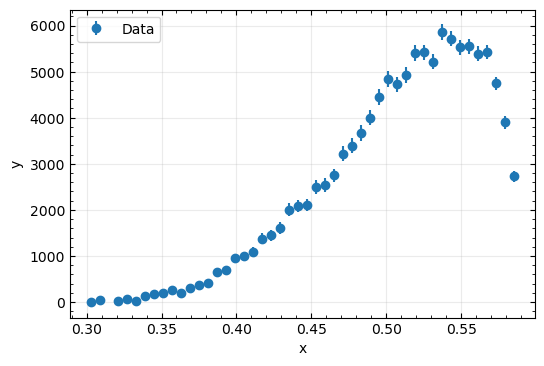

In [15]:
data_df = DataFrame!(CSV.File("./testdata.csv"))
const data = Data(data_df)

plt_data(data)

In [16]:
const M = 3.686; const mπ = 0.14; const mJ = 3.097; 

λ(x, y, z) = x^2 + y^2 + z^2 - 2x*y - 2y*z - 2z*x

# a simple function that will be used to fit the data: QCD multipole expansion model for ψ'→J/ψπ⁺π⁻
# The important ππ FSI effect is not taken into account
# bg is just for introducing a third parameter
function dist(w, N, c, bg) 
    if (w ≤ 2mπ || w ≥ M-mJ)
        res = 0.0
    else
        q1 = sqrt(λ(w^2, mπ^2, mπ^2))/(2w)
        q2 = sqrt(λ(M^2, w^2, mJ^2))/(2M)
        res = N * q1 * q2 * (w^2 - c*mπ^2)^2 + bg
    end
    return res * 1e6
end

dist(w, par) = dist(w, par...);

In [17]:
χsq(N, c, bg) = chisq(dist, data, (N, c, bg))

# parameters in an array/tuple
χsq1(par) = chisq(dist, data, par)

χsq1 (generic function with 1 method)

In [23]:
# all parameters are vairables of χsq
fit = Minuit(χsq, N = 1, c = 2, bg = 0, error_N = 0.1, error_c = 0.1, error_bg = 0.1)
fit.strategy = 1;

In [24]:
# parameters are collected into a tuple or an array, which is the only variable of χsq
gradf(par) = gradient(χsq1, par)
fit1 = Minuit(χsq1, [1, 2, 0], error = 0.1*ones(3), grad = gradf)
fit1.strategy = 1;

In [25]:
@btime migrad(fit)

  102.300 μs (565 allocations: 10.80 KiB)


PyObject MigradResult(fmin=FMin(fval=64.679937335079, edm=1.5156345070287753e-14, tolerance=0.1, nfcn=14, ncalls=478824, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='N', value=2.6114833211935484, error=0.051776712195704004, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='c', value=4.201031344545451, error=0.09311685621270735, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='bg', value=-2.192118618207932e-05, error=1.1895620973146581e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [26]:
@btime migrad(fit1)

  138.500 μs (1519 allocations: 41.52 KiB)


PyObject MigradResult(fmin=FMin(fval=64.67993733507895, edm=9.357751294516442e-15, tolerance=0.1, nfcn=3, ncalls=73653, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='x0', value=2.6114833151653025, error=0.05177673323060879, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='x1', value=4.201031332818215, error=0.09311776395965805, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='x2', value=-2.1921187450274414e-05, error=1.1895993246464892e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

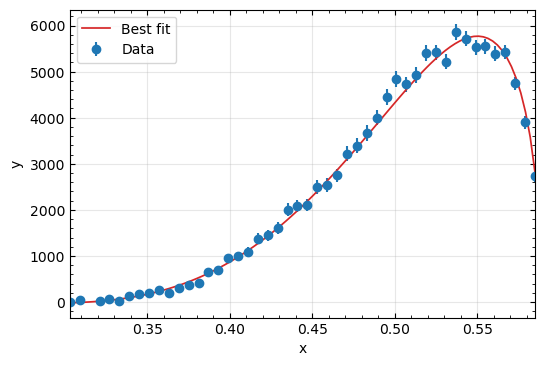

In [27]:
plt_best(dist, fit, data)

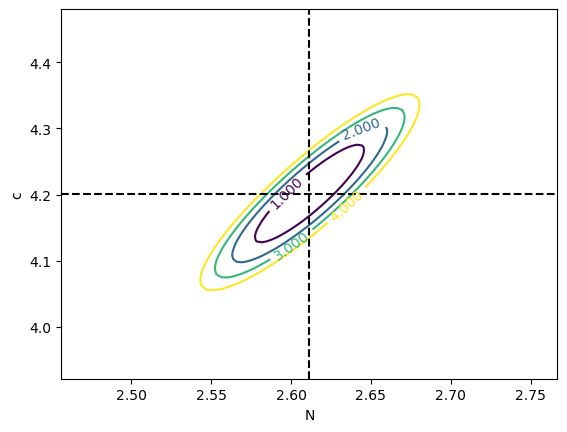

In [28]:
# MIGRAD contour of two parameters with the other ones fixed
fit.draw_contour(:N, :c, bound=3, bins=100);

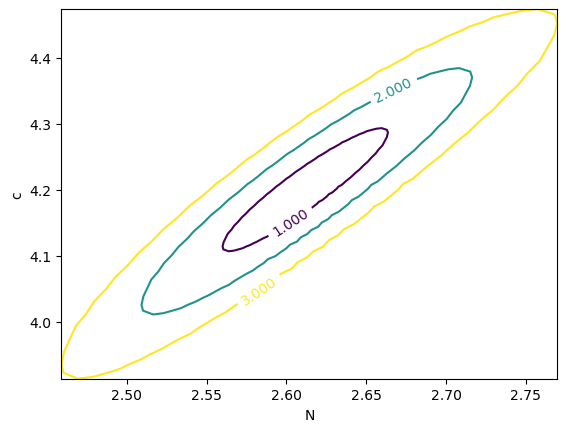

PyObject <matplotlib.contour.ContourSet object at 0x7f969f5b9c10>

In [29]:
# contour of parameter space from MINOS
fit.draw_mncontour(:N, :c, nsigma=3, numpoints=100)

In [30]:
matrix(fit1)

PyObject ((0.002680830104033628, 0.00446076519213962, 3.729691098783947e-07), (0.00446076519213962, 0.008670917964846593, 8.290287403849337e-07), (3.729691098783947e-07, 8.290287403849337e-07, 1.4151465531993833e-10))

In [31]:
fit1.matrix

((0.002680830104033628, 0.00446076519213962, 3.729691098783947e-7), (0.00446076519213962, 0.008670917964846593, 8.290287403849337e-7), (3.729691098783947e-7, 8.290287403849337e-7, 1.4151465531993833e-10))

In [34]:
# this gives parameter sets at the 1σ boundary
contour_df(fit, χsq, npts = 5)

,χ²,N,c,bg
,Float64,Float64,Float64,Float64
1,64.6799,2.61148,4.20103,-2.19212e-5
2,65.6799,2.56003,4.11417,-2.93098e-5
3,65.6799,2.66359,4.28645,-1.48651e-5
4,65.68,2.56388,4.10711,-3.10214e-5
5,65.68,2.65949,4.29336,-1.32599e-5
6,65.6799,2.57965,4.12983,-3.39527e-5
7,65.6799,2.64229,4.26913,-1.01556e-5
8,65.68,2.56003,4.11439,-2.92436e-5
9,65.6799,2.5638,4.10711,-3.10202e-5


In [37]:
# Monte Carlo sampling of parameters in given ranges, keeping those within 1σ
contour_df_samples(fit, χsq, (:N, :c), ([2.5,2.8], [4.0,4.3]), nsamples = 500)

,χ²,N,c,bg
,Float64,Float64,Float64,Float64
1,64.6799,2.61148,4.20103,-2.19212e-5
2,65.3612,2.61483,4.23567,-1.66425e-5
3,65.6108,2.56673,4.11062,-3.08476e-5
4,64.951,2.59559,4.18938,-2.16563e-5
5,65.293,2.57154,4.12986,-2.82745e-5
6,65.5187,2.65631,4.28557,-1.40922e-5
7,65.3778,2.65451,4.26754,-1.67775e-5
8,65.4507,2.57936,4.12505,-3.01915e-5
9,64.8153,2.60581,4.17916,-2.47807e-5


## Example A in the iminuit tutorial

The example is [Example A: Fit of a gaussian model to a histogram](https://nbviewer.jupyter.org/github/scikit-hep/iminuit/blob/master/tutorial/automatic_differentiation.ipynb)

In [14]:
using PyCall
using BenchmarkTools

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1260


In [8]:
# import numpy from Python to generate the same data as in the example
np = pyimport(:numpy)
default_rng = pyimport("numpy.random").default_rng
rng = default_rng(seed=1)
const w, xe = np.histogram(rng.normal(0, 1, 10000), bins=1000)

([1, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [-3.8378621427178974, -3.830092502694802, -3.8223228626717063, -3.8145532226486107, -3.806783582625515, -3.7990139426024196, -3.791244302579324, -3.7834746625562286, -3.775705022533133, -3.7679353825100375  …  3.8618511201697956, 3.869620760192891, 3.8773904002159867, 3.8851600402390822, 3.892929680262178, 3.9006993202852733, 3.908468960308369, 3.9162386003314644, 3.92400824035456, 3.931777880377655])

In [9]:
# define the model and the score function to minimize
using SpecialFunctions

function cdf(x, par)
    mu, sigma = par
    z = (x - mu) / sigma
    return 0.5 * (1 + erf(z / sqrt(2))) 
end

function score(par)
    amp = par[1]
    rest = par[2:end]
    mu = amp * (cdf.(xe[2:end], Ref(rest)) - cdf.(xe[1:end-1], Ref(rest)) )
    return 2 * sum(@. mu - w * log(mu + 1e-100))
end

score (generic function with 1 method)

In [10]:
const start_values = [1.5 * sum(w), 1.0, 2.0]
const limits = [(0, nothing), nothing, (0, nothing)]

3-element Array{Union{Nothing, Tuple{Int64,Nothing}},1}:
 (0, nothing)
 nothing
 (0, nothing)

In [11]:
# w/o grad
m = Minuit(score, start_values, limit=limits)
m.strategy = 0

# using grad
grad_fd(pars) =  gradient(score, pars)
m_fd = Minuit(score, start_values, limit=limits, grad = grad_fd)
m_fd.strategy = 0;

In [15]:
@btime migrad(m)

  701.800 μs (475 allocations: 460.64 KiB)


PyObject MigradResult(fmin=FMin(fval=-38710.19985212475, edm=2.0142820069460498e-12, tolerance=0.1, nfcn=8, ncalls=38908, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='x0', value=10001.040137685515, error=99.56265139939478, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=False, lower_limit=0.0, upper_limit=None), Param(number=1, name='x1', value=-0.01105171350465089, error=0.010013546547205668, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='x2', value=0.9992897105689829, error=0.007141203766656945, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=False, lower_limit=0.0, upper_limit=None)])

In [16]:
@btime migrad(m_fd)

  451.100 μs (257 allocations: 348.22 KiB)


PyObject MigradResult(fmin=FMin(fval=-38710.19985212736, edm=9.414200054796711e-12, tolerance=0.1, nfcn=3, ncalls=22175, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='x0', value=10001.039987391317, error=99.95742260033421, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=False, lower_limit=0.0, upper_limit=None), Param(number=1, name='x1', value=-0.011051729329187911, error=0.009992544958620243, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='x2', value=0.9992893655857928, error=0.00710107169380747, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=False, lower_limit=0.0, upper_limit=None)])